# Fuzzy Neural Networks (FNN) — Notebook 1  
### Grid-partition fuzzification (Gaussian MFs), rule explosion, and interpretability (using your `FNNModel`)

**Seminar (Day 1)** — Universidad Carlos III de Madrid  
**Instructor:** Prof. Doutor Paulo Vitor de Campos Souza  

---

## What this notebook is for

This is a *presentation notebook*: every executable cell produces an output (a plot and/or short printed summary),
so you can keep a dynamic pace during the seminar.

We will walk through your FNN as a **3-layer architecture**:

1) **Layer 1 — Fuzzification (Grid Partition):** Gaussian membership functions create *Gaussian neurons*  
   and (optionally) feature-level weights can be adjusted by **data density** for interpretability.

2) **Layer 2 — Logic / Rule Layer:** AND / OR neurons aggregate the MF activations into **fuzzy rules**.  
   The rule consequents (output weights) are estimated using **Moore–Penrose pseudo-inverse**  
   (we mention PSO / other optimizers as research extensions).

3) **Layer 3 — Output / Defuzzification:** a **singleton** output produces the final crisp prediction.

Finally, we compute interpretability diagnostics such as:
- **Consistency** (between consequents),
- **Similarity** (between rule parameters),
- **Distinguishability / overlap** (between antecedent Gaussians),
- **Completeness** (coverage of samples by rules).

---

## 0) Imports and a note about project structure

In your full project, the model is typically imported as:

```python
from models.models import FNNModel
```

(as in your experiment runner script).
This notebook tries that first. If you are running from a single folder (only `models.py` available),
it will automatically fall back to a local import.

> For the UC3M seminar zip, I recommend shipping the full folder structure so the first import works.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True

# --- Load FNNModel (preferred path: full project) ---
try:
    from models.models import FNNModel
    print("✓ Imported FNNModel from full project path: models.models.FNNModel")
except Exception as e_full:
    print("Full-project import failed:", repr(e_full))
    print("Trying local fallback import from ./models.py ...")
    import importlib.util, pathlib
    p = pathlib.Path("./models.py")
    if not p.exists():
        # also try the sandbox location if needed
        p = pathlib.Path("/mnt/data/models.py")
    spec = importlib.util.spec_from_file_location("models_local", p)
    models_local = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(models_local)
    FNNModel = models_local.FNNModel
    print(f"✓ Imported FNNModel from: {p}")

print("FNNModel:", FNNModel)

✓ Imported FNNModel from full project path: models.models.FNNModel
FNNModel: <class 'models.models.FNNModel'>


---

## 1) Dataset: Iris (binary)

Your `FNNModel` evaluation uses `sign()` and expects **binary labels** in **{-1, +1}**.
For a clean, well-known demo we turn Iris into a binary problem:

- +1: *setosa*
- -1: *versicolor*
(we ignore *virginica* in this notebook)

This is perfect to visualize fuzzification and rules because we have **4 input features**.

In [54]:
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind

# --------------------------------------------------
# 1) Build DataFrame for analysis
# --------------------------------------------------
df = pd.DataFrame(X, columns=feature_names)
df["class"] = np.where(y == 1, "Setosa (+1)", "Versicolor (-1)")

print("✓ DataFrame created")
df.head()


✓ DataFrame created


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,Versicolor (-1)
1,4.9,3.0,1.4,0.2,Versicolor (-1)
2,4.7,3.2,1.3,0.2,Versicolor (-1)
3,4.6,3.1,1.5,0.2,Versicolor (-1)
4,5.0,3.6,1.4,0.2,Versicolor (-1)


This statistical analysis provides a quantitative justification for the placement and spread of membership functions. Features with higher inter-class separation tend to generate more discriminative fuzzy rules.

In [55]:
# --------------------------------------------------
# 2) Descriptive statistics per class
# --------------------------------------------------
stats = []

for feat in feature_names:
    x_pos = df[df["class"] == "Setosa (+1)"][feat].values
    x_neg = df[df["class"] == "Versicolor (-1)"][feat].values

    mean_pos, mean_neg = x_pos.mean(), x_neg.mean()
    std_pos, std_neg = x_pos.std(ddof=1), x_neg.std(ddof=1)
    med_pos, med_neg = np.median(x_pos), np.median(x_neg)

    # Effect size: Cohen's d
    pooled_std = np.sqrt((std_pos**2 + std_neg**2) / 2)
    cohens_d = (mean_pos - mean_neg) / pooled_std if pooled_std > 0 else 0.0

    # Welch t-test (robust to unequal variances)
    t_stat, p_val = ttest_ind(x_pos, x_neg, equal_var=False)

    stats.append({
        "Feature": feat,
        "Mean (+1)": mean_pos,
        "Mean (-1)": mean_neg,
        "Std (+1)": std_pos,
        "Std (-1)": std_neg,
        "Median (+1)": med_pos,
        "Median (-1)": med_neg,
        "Δ Mean": mean_pos - mean_neg,
        "Cohen's d": cohens_d,
        "p-value (Welch)": p_val
    })

stats_df = pd.DataFrame(stats)
stats_df


,Feature,Mean (+1),Mean (-1),Std (+1),Std (-1),Median (+1),Median (-1),Δ Mean,Cohen's d,p-value (Welch)
0,sepal length (cm),5.936,5.797,0.516171,0.945319,5.90,5.7,0.139,0.182511,2.463912e-01
1,sepal width (cm),2.770,3.201,0.313798,0.417906,2.80,3.2,-0.431,-1.166325,9.512846e-11
2,petal length (cm),4.260,3.507,0.469911,2.095221,4.35,3.2,0.753,0.495933,8.454501e-04
3,petal width (cm),1.326,1.136,0.197753,0.918114,1.30,1.0,0.190,0.286104,5.010645e-02


In [57]:
# --------------------------------------------------
# 3) Highlight statistically relevant features (fixed)
# --------------------------------------------------

stats_df2 = stats_df.copy()

# Choose ONE magnitude column to sort by:
# Option A (recommended): absolute effect size
stats_df2["|Cohen's d|"] = stats_df2["Cohen's d"].abs()

# Option B: absolute mean difference (also useful)
stats_df2["|Δ Mean|"] = stats_df2["Δ Mean"].abs()

# Sort by p-value first, then by effect size magnitude
stats_df_sorted = stats_df2.sort_values(
    by=["p-value (Welch)", "|Cohen's d|"],
    ascending=[True, False]
)

print("✓ Features ranked by statistical separation (Welch test + effect size):")
stats_df_sorted[["Feature", "Δ Mean", "|Δ Mean|", "Cohen's d", "|Cohen's d|", "p-value (Welch)"]]


✓ Features ranked by statistical separation (Welch test + effect size):


,Feature,Δ Mean,|Δ Mean|,Cohen's d,|Cohen's d|,p-value (Welch)
1,sepal width (cm),-0.431,0.431,-1.166325,1.166325,9.512846e-11
2,petal length (cm),0.753,0.753,0.495933,0.495933,8.454501e-04
3,petal width (cm),0.190,0.190,0.286104,0.286104,5.010645e-02
0,sepal length (cm),0.139,0.139,0.182511,0.182511,2.463912e-01


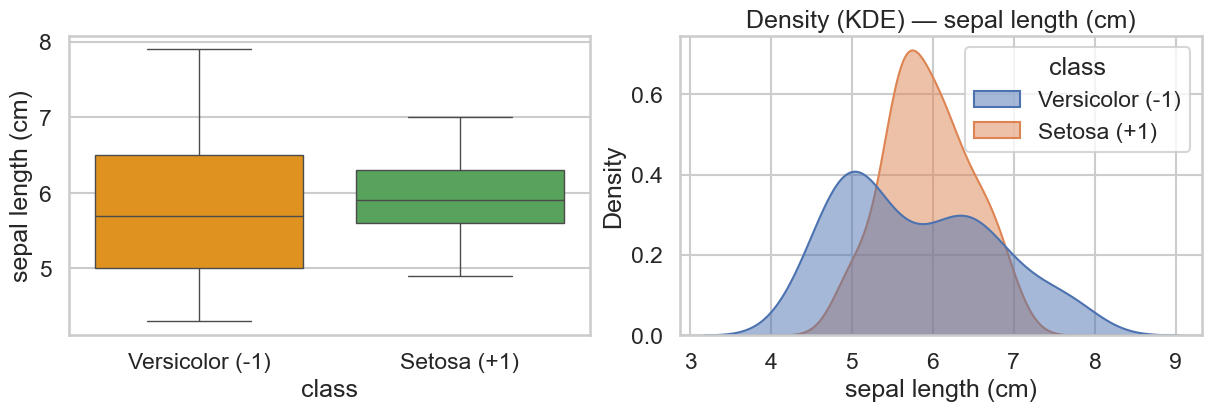

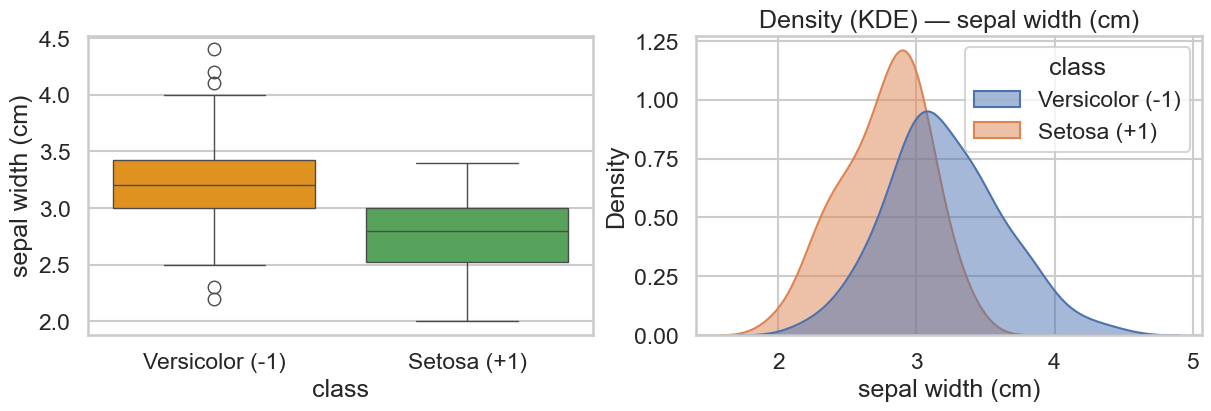

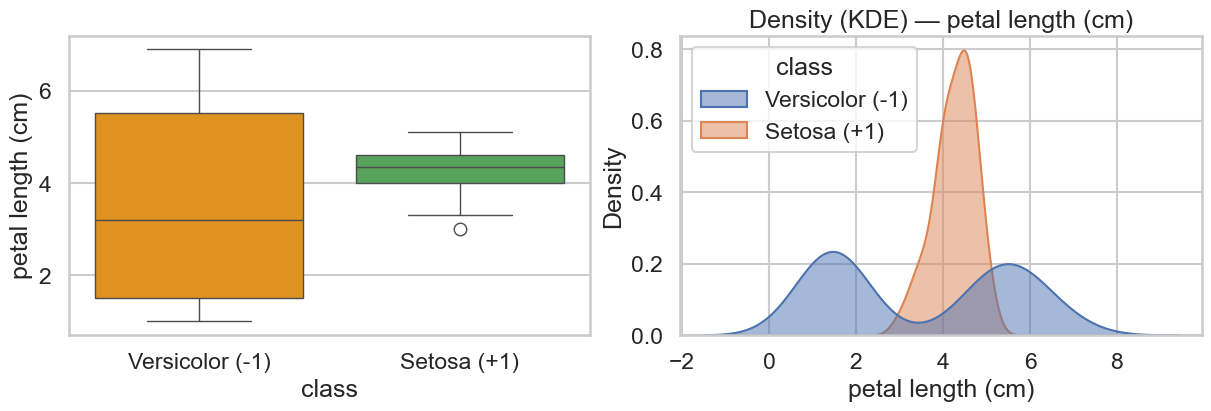

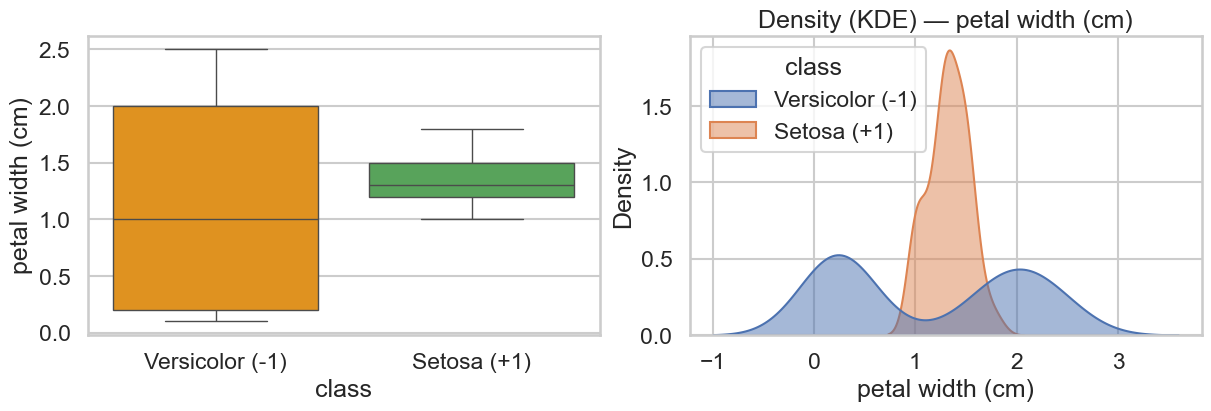

In [59]:
# --------------------------------------------------
# 4) Visualization: boxplots + KDEs
# --------------------------------------------------
sns.set(style="whitegrid", context="talk")

for feat in feature_names:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    # Boxplot
    sns.boxplot(
        data=df,
        x="class",
        y=feat,
        hue="class",
        palette={"Setosa (+1)": "#4CAF50", "Versicolor (-1)": "#FF9800"},
        legend=False,
        ax=axes[0]
)
    # KDE
    sns.kdeplot(
        data=df, x=feat, hue="class",
        fill=True, common_norm=False,
        alpha=0.5, ax=axes[1]
    )
    axes[1].set_title(f"Density (KDE) — {feat}")

    plt.show()


---

## 2) The core knobs

These parameters are the easiest way to show the main effects:

- `NUM_MFS`: 2 → 3 → 4 (watch the rule explosion)
- `NEURON_TYPE`: AND / OR / UNINORM
- `OPTIMIZER`: Moore–Penrose (fast & didactic), plus PSO/Adam as research options
- `PRUNING`: keep `"none"` for the seminar baseline

> Tip: During the talk, change only **one** knob at a time so the audience can attribute the effect.

In [43]:
NUM_MFS = 2                 # try: 2, 3, 4
NEURON_TYPE = "orneuron"   # "andneuron" | "orneuron" |
ACTIVATION = "linear"       # best match for pseudo-inverse explanation
OPTIMIZER = "moore-penrose" # "moore-penrose" | "pso" | "adam"
PRUNING = "none"            # keep 'none' for the seminar baseline

print("✓ Knobs set")
print(dict(NUM_MFS=NUM_MFS, NEURON_TYPE=NEURON_TYPE, ACTIVATION=ACTIVATION, OPTIMIZER=OPTIMIZER, PRUNING=PRUNING))

✓ Knobs set
{'NUM_MFS': 2, 'NEURON_TYPE': 'orneuron', 'ACTIVATION': 'linear', 'OPTIMIZER': 'moore-penrose', 'PRUNING': 'none'}


---

## 3) Layer 1 — Fuzzification (Gaussian MFs, grid partition)

Conceptually:

- For each feature, we define `NUM_MFS` membership functions (MFs) using a **grid partition** strategy.
- In your implementation, the MFs are **Gaussians**, producing *Gaussian neurons*.
- Each sample is transformed into a set of MF activation values (degrees of membership).

If `visualizeMF=True`, the model will plot the Gaussian MFs for each feature.

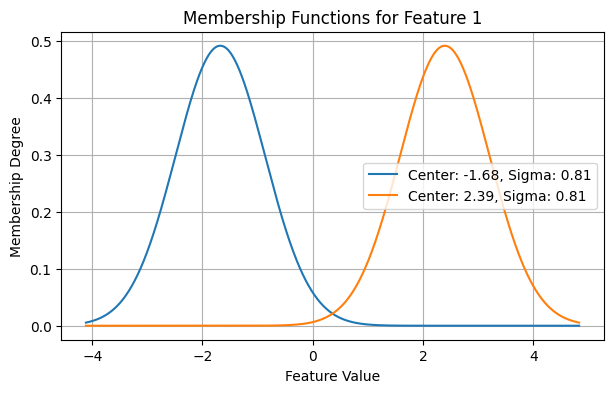

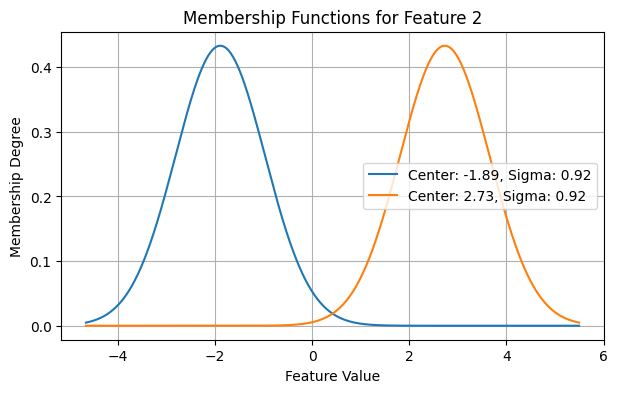

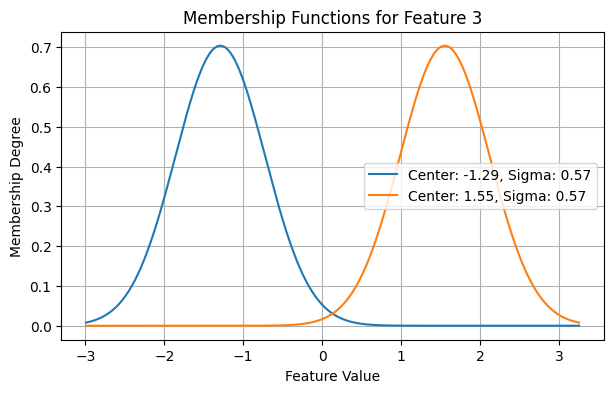

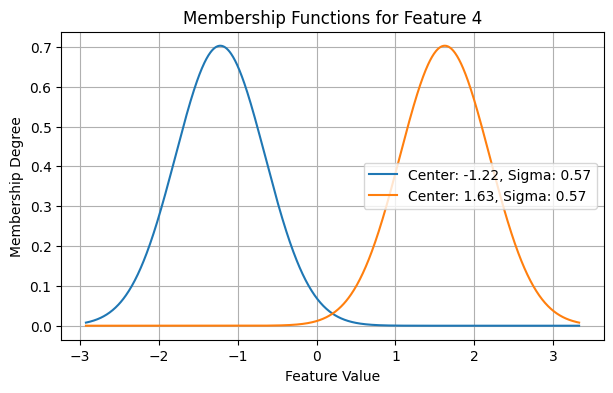

✓ Fuzzification completed
F shape (MF activations): (70, 16)
MF activations per sample should be num_mfs * num_features = 8
num_features: 4


In [44]:
model = FNNModel(
    num_mfs=NUM_MFS,
    neuron_type=NEURON_TYPE,
    activation=ACTIVATION,
    optimizer=OPTIMIZER,
    pruning=PRUNING,
    visualizeMF=True,
    rng_seed=np.random.default_rng(42),
)

F = model.fuzzification_layer(X_train)

print("✓ Fuzzification completed")
print("F shape (MF activations):", F.shape)
print("MF activations per sample should be num_mfs * num_features =", NUM_MFS * X_train.shape[1])
print("num_features:", X_train.shape[1])

### Rule explosion (a key seminar moment)

With `d` input features and `m` membership functions per feature:

\[
\text{#rules} = m^d
\]

For Iris (d=4):
- 2 MFs → 16 rules
- 3 MFs → 81 rules
- 4 MFs → 256 rules

This is why interpretability often involves:
- pruning / merging,
- or evolving strategies to control complexity (Day 2).

In [45]:
d = X_train.shape[1]
for m in [2, 3, 4, 5]:
    print(f"num_mfs={m:>2}  ->  rules = {m**d:>6}")
print("✓ Rule explosion printed")

num_mfs= 2  ->  rules =     16
num_mfs= 3  ->  rules =     81
num_mfs= 4  ->  rules =    256
num_mfs= 5  ->  rules =    625
✓ Rule explosion printed


---

## 4) Gaussian vs Triangular membership functions (live visual comparison)

Your model uses **Gaussian** MFs.  
A natural research question is: *what happens if we replace the fuzzification with triangular MFs?*

- Gaussian: smooth tails, differentiable, very common in neuro-fuzzy models  
- Triangular: piecewise-linear, often perceived as more “linguistic” / interpretable

Below we **do not modify the model** (we keep training Gaussian),
but we plot Gaussian vs Triangular side-by-side using the **same centers** learned during fuzzification.
This gives a very clear visual for the audience.

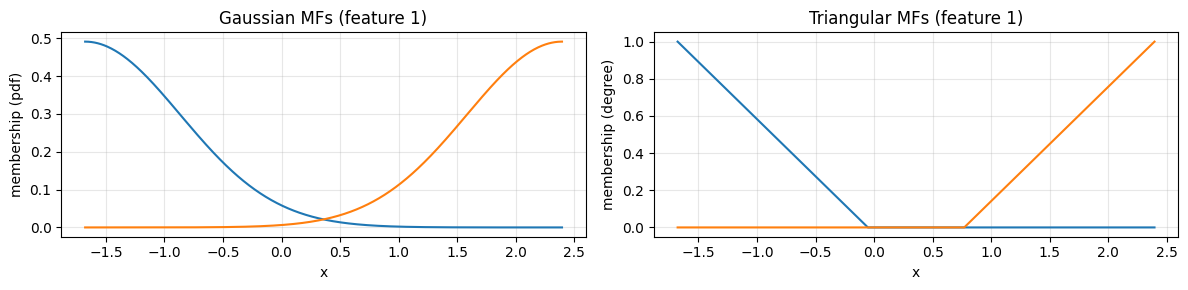

✓ Gaussian vs Triangular plotted
Centers: [-1.677  2.395]
Sigmas : [0.812 0.812]
Triangle half-width multiplier k = 2.0


In [46]:
from scipy.stats import norm

def triangular_mf(x, a, b, c):
    x = np.asarray(x, dtype=float)
    y = np.zeros_like(x)
    left = (a < x) & (x <= b)
    y[left] = (x[left] - a) / (b - a + 1e-12)
    right = (b < x) & (x < c)
    y[right] = (c - x[right]) / (c - b + 1e-12)
    y[x == b] = 1.0
    return np.clip(y, 0, 1)

# Choose a feature to visualize
feat = 0  # change to 1,2,3 during the talk

centers = np.array(model.mf_params[feat]["centers"], dtype=float)
sigmas  = np.array(model.mf_params[feat]["sigmas"], dtype=float)

xcol = X_train[:, feat]
xs = np.linspace(xcol.min(), xcol.max(), 600)

# Build triangles with half-width proportional to sigma (demo choice)
k = 2.0
tri_params = [(c - k*s, c, c + k*s) for c, s in zip(centers, sigmas)]

fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# Gaussian MFs
for c, s in zip(centers, sigmas):
    axes[0].plot(xs, norm.pdf(xs, c, s))
axes[0].set_title(f"Gaussian MFs (feature {feat+1})")
axes[0].set_xlabel("x"); axes[0].set_ylabel("membership (pdf)")
axes[0].grid(alpha=0.3)

# Triangular MFs
for (a, b, c) in tri_params:
    axes[1].plot(xs, triangular_mf(xs, a, b, c))
axes[1].set_title(f"Triangular MFs (feature {feat+1})")
axes[1].set_xlabel("x"); axes[1].set_ylabel("membership (degree)")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Gaussian vs Triangular plotted")
print("Centers:", np.round(centers, 3))
print("Sigmas :", np.round(sigmas, 3))
print("Triangle half-width multiplier k =", k)

The decision on which form of fuzzification to choose for your model can determine complexity in several aspects, including interpretability.

✓ Iris loaded: (150, 2)
Features: petal length (cm) and petal width (cm)
✓ Grid centers (feature 1): [1.   3.95 6.9 ]
✓ Cluster centers (feature 1): [1.46 4.23 5.56]


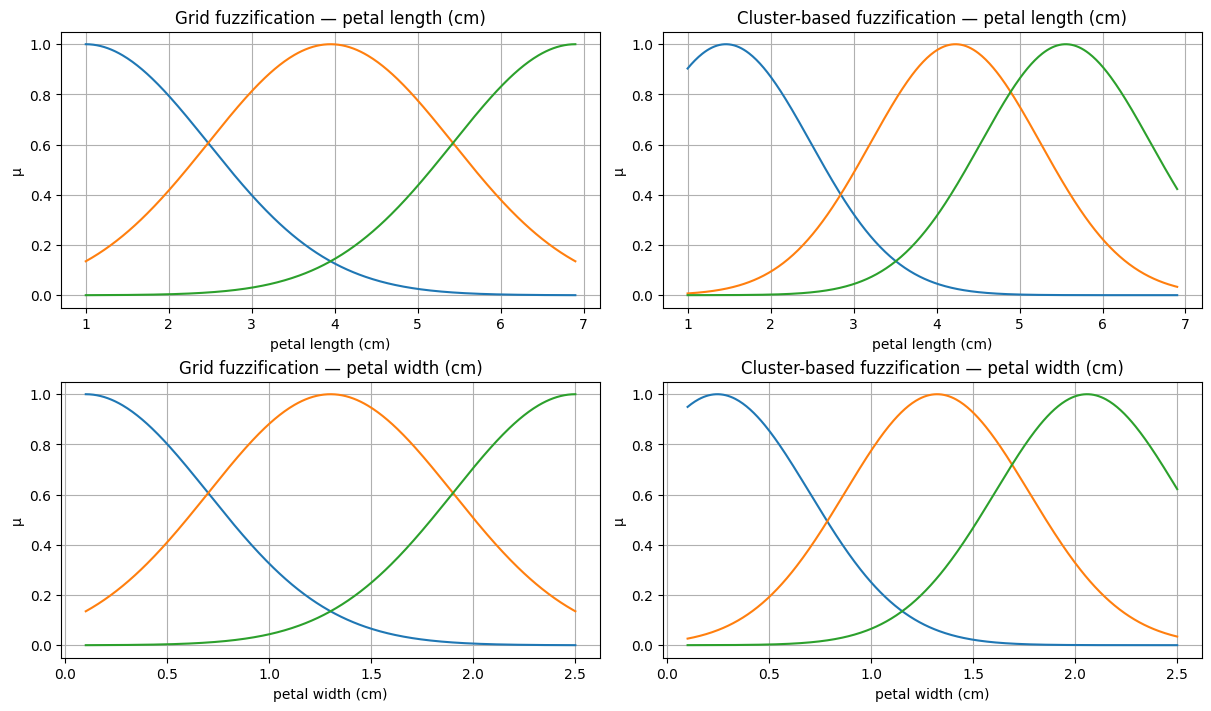

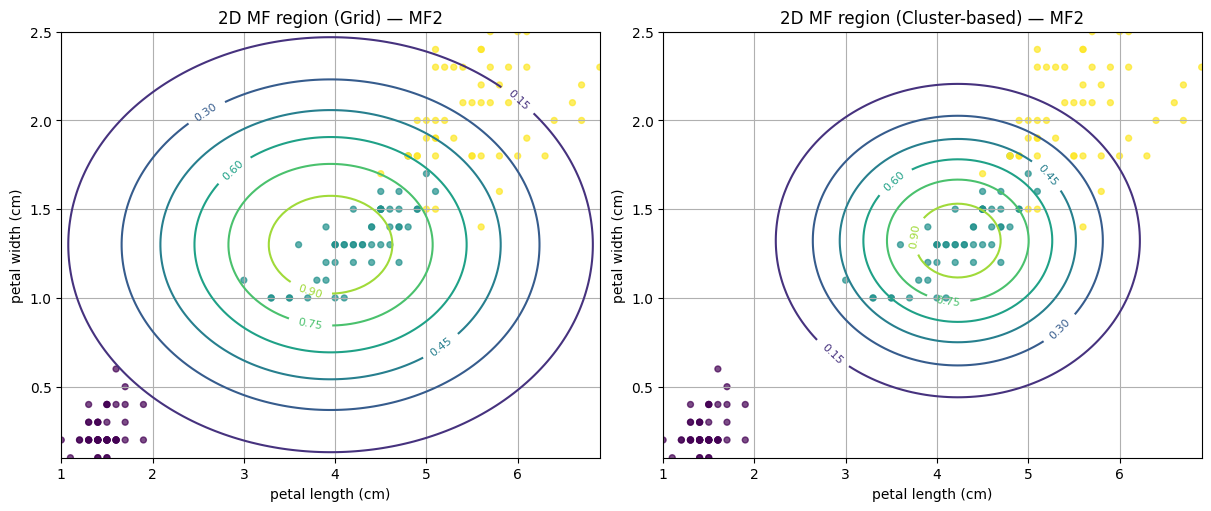

✓ Done: Grid vs Cluster fuzzification visual comparison.


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# ---------------------------
# 1) Load Iris and pick 2 features
# ---------------------------
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names

# Pick 2 features for visualization (edit if you want)
f1, f2 = 2, 3  # petal length, petal width (usually very separable)
X2 = X[:, [f1, f2]]

# Standardize for clustering stability (recommended)
scaler = StandardScaler()
X2s = scaler.fit_transform(X2)

print("✓ Iris loaded:", X2.shape)
print("Features:", feature_names[f1], "and", feature_names[f2])

# ---------------------------
# 2) Helpers: Gaussian MF
# ---------------------------
def gaussian_mf(x, c, s):
    s = max(float(s), 1e-9)
    return np.exp(-0.5 * ((x - c) / s) ** 2)

def grid_centers_sigmas(x, m=3):
    # evenly spaced centers across data range
    xmin, xmax = float(np.min(x)), float(np.max(x))
    centers = np.linspace(xmin, xmax, m)
    # sigma: spacing-based (simple heuristic)
    if m > 1:
        spacing = centers[1] - centers[0]
        sigma = spacing / 2.0
    else:
        sigma = (xmax - xmin) / 2.0 if xmax > xmin else 1.0
    sigmas = np.full_like(centers, sigma, dtype=float)
    return centers, sigmas

def cluster_centers_sigmas(x, k=3, random_state=0):
    # 1D KMeans on a single feature
    km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    km.fit(x.reshape(-1, 1))
    centers = np.sort(km.cluster_centers_.ravel())
    # sigma: average distance to nearest center (heuristic)
    if k > 1:
        spacing = np.mean(np.diff(centers))
        sigma = spacing / 2.0
    else:
        sigma = np.std(x) if np.std(x) > 0 else 1.0
    sigmas = np.full_like(centers, sigma, dtype=float)
    return centers, sigmas

# ---------------------------
# 3) Build MFs for both features
# ---------------------------
m = 3  # number of MFs / clusters (edit: 2,3,4)

x1 = X2[:, 0]
x2 = X2[:, 1]

# Grid
c1g, s1g = grid_centers_sigmas(x1, m=m)
c2g, s2g = grid_centers_sigmas(x2, m=m)

# Cluster-based (use standardized for clustering, but plot in original scale)
c1c_s, s1c_s = cluster_centers_sigmas(X2s[:, 0], k=m, random_state=0)
c2c_s, s2c_s = cluster_centers_sigmas(X2s[:, 1], k=m, random_state=0)

# Convert cluster centers back to original scale for plotting MFs
c1c = scaler.mean_[0] + c1c_s * scaler.scale_[0]
c2c = scaler.mean_[1] + c2c_s * scaler.scale_[1]
# Sigmas back to original scale
s1c = s1c_s * scaler.scale_[0]
s2c = s2c_s * scaler.scale_[1]

print("✓ Grid centers (feature 1):", np.round(c1g, 2))
print("✓ Cluster centers (feature 1):", np.round(c1c, 2))

# ---------------------------
# 4) Plot 1D fuzzification side-by-side
# ---------------------------
xx1 = np.linspace(np.min(x1), np.max(x1), 400)
xx2 = np.linspace(np.min(x2), np.max(x2), 400)

fig, axes = plt.subplots(2, 2, figsize=(12, 7), constrained_layout=True)

# Feature 1: Grid vs Cluster
axes[0, 0].set_title(f"Grid fuzzification — {feature_names[f1]}")
for c, s in zip(c1g, s1g):
    axes[0, 0].plot(xx1, gaussian_mf(xx1, c, s))
axes[0, 0].set_xlabel(feature_names[f1]); axes[0, 0].set_ylabel("μ")

axes[0, 1].set_title(f"Cluster-based fuzzification — {feature_names[f1]}")
for c, s in zip(c1c, s1c):
    axes[0, 1].plot(xx1, gaussian_mf(xx1, c, s))
axes[0, 1].set_xlabel(feature_names[f1]); axes[0, 1].set_ylabel("μ")

# Feature 2: Grid vs Cluster
axes[1, 0].set_title(f"Grid fuzzification — {feature_names[f2]}")
for c, s in zip(c2g, s2g):
    axes[1, 0].plot(xx2, gaussian_mf(xx2, c, s))
axes[1, 0].set_xlabel(feature_names[f2]); axes[1, 0].set_ylabel("μ")

axes[1, 1].set_title(f"Cluster-based fuzzification — {feature_names[f2]}")
for c, s in zip(c2c, s2c):
    axes[1, 1].plot(xx2, gaussian_mf(xx2, c, s))
axes[1, 1].set_xlabel(feature_names[f2]); axes[1, 1].set_ylabel("μ")

plt.show()

# ---------------------------
# 5) (Optional, very nice) 2D view: show MF "regions"
# Pick one MF index to visualize as a contour
# ---------------------------
mf_idx = 1  # 0..m-1
grid_res = 120

x1_grid = np.linspace(np.min(x1), np.max(x1), grid_res)
x2_grid = np.linspace(np.min(x2), np.max(x2), grid_res)
Xg1, Xg2 = np.meshgrid(x1_grid, x2_grid)

# Example: product of membership degrees in 2D (AND-like)
Z_grid = gaussian_mf(Xg1, c1g[mf_idx], s1g[mf_idx]) * gaussian_mf(Xg2, c2g[mf_idx], s2g[mf_idx])
Z_clst = gaussian_mf(Xg1, c1c[mf_idx], s1c[mf_idx]) * gaussian_mf(Xg2, c2c[mf_idx], s2c[mf_idx])

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

axes[0].set_title(f"2D MF region (Grid) — MF{mf_idx+1}")
axes[0].scatter(x1, x2, c=y, s=18, alpha=0.7)
cs0 = axes[0].contour(Xg1, Xg2, Z_grid, levels=6)
axes[0].clabel(cs0, inline=True, fontsize=8)
axes[0].set_xlabel(feature_names[f1]); axes[0].set_ylabel(feature_names[f2])

axes[1].set_title(f"2D MF region (Cluster-based) — MF{mf_idx+1}")
axes[1].scatter(x1, x2, c=y, s=18, alpha=0.7)
cs1 = axes[1].contour(Xg1, Xg2, Z_clst, levels=6)
axes[1].clabel(cs1, inline=True, fontsize=8)
axes[1].set_xlabel(feature_names[f1]); axes[1].set_ylabel(feature_names[f2])

plt.show()

print("✓ Done: Grid vs Cluster fuzzification visual comparison.")


---

## 5) Layer 2 — Logic neurons ⇒ fuzzy rules (AND / OR )

In your architecture, the second layer aggregates MF activations into **rule activations** using a logic neuron:

- AND neuron: tends to be more “selective” (requires all antecedents to be high)
- OR neuron: tends to be more “inclusive”

Your implementation supports those options via `neuron_type`.

In [47]:
A = model.logic_neurons_layer(F)
print("✓ Logic / rule layer computed")
print("A shape (rule activations):", A.shape)
print("Expected #rules:", NUM_MFS ** X_train.shape[1])
print("Rule activation stats: min={:.3e}, mean={:.3e}, max={:.3e}".format(A.min(), A.mean(), A.max()))

✓ Logic / rule layer computed
A shape (rule activations): (70, 16)
Expected #rules: 16
Rule activation stats: min=7.007e-05, mean=5.314e-01, max=9.567e-01


---

## 6) Rule consequents via Moore–Penrose pseudo-inverse (training)

In your pipeline, once the rule activations are computed, the rule consequents (output weights) are estimated.
For the seminar we focus on the **Moore–Penrose pseudo-inverse** because it is:

- fast,
- closed-form,
- very easy to explain as “linear regression on rule features”.

You also support other optimizers (PSO/Adam) as active research directions (mentioned but not executed live). 

In [48]:
model.train_model(X_train, y_train)
y_pred, metrics = model.evaluate_model(X_test, y_test)

print("✓ Training + evaluation done")
print("Metrics:", metrics)
print("V shape (rule consequents / output weights):", np.asarray(model.V).shape)
print("Pred sample:", y_pred[:10])

Number of rules before pruning: 16
Unsupported pruning method. Proceding with all the neurons

Accuracy: 100.00%
Specificity: 0.9999999993333333
Precision: 0.9999999993333333
Recall: 0.9999999993333333
F-Score: 0.9999999943333333
✓ Training + evaluation done
Metrics: {'accuracy': 1.0, 'specificity': 1.0, 'precision': 1.0, 'recall': 1.0, 'fscore': 1.0}
V shape (rule consequents / output weights): (16,)
Pred sample: [-1. -1.  1. -1. -1.  1.  1.  1.  1. -1.]


---

## 7) Interpretable fuzzy rules (text and image)

A key advantage of your approach is that it can *export* fuzzy rules in a readable form.
In the seminar, it is usually enough to show the first ~5 rules and discuss:

- the MF index per feature,
- the rule consequent sign/magnitude,
- and how this ties back to the decision.

In [49]:
rules = model.generate_fuzzy_rules()
print("✓ Rules generated:", len(rules))
for r in rules[:5]:
    print("-", r)

✓ Rules generated: 16
- IF x1 is MF1 with impact 0.72 OR x2 is MF1 with impact 0.22 OR x3 is MF1 with impact 0.43 OR x4 is MF1 with impact 0.35 THEN output is -14.212739576518366
- IF x1 is MF1 with impact 0.07 OR x2 is MF1 with impact 0.49 OR x3 is MF1 with impact 0.38 OR x4 is MF2 with impact 0.39 THEN output is 20.869700122266153
- IF x1 is MF1 with impact 0.06 OR x2 is MF1 with impact 0.38 OR x3 is MF2 with impact 0.19 OR x4 is MF1 with impact 0.46 THEN output is 12.302671218326765
- IF x1 is MF1 with impact 0.32 OR x2 is MF1 with impact 0.53 OR x3 is MF2 with impact 0.22 OR x4 is MF2 with impact 0.11 THEN output is -13.044812366230275
- IF x1 is MF1 with impact 0.28 OR x2 is MF2 with impact 0.03 OR x3 is MF1 with impact 1.00 OR x4 is MF1 with impact 0.32 THEN output is 12.7062240157342


In [50]:
import numpy as np

# -----------------------------
# 1) Customize labels (edit here)
# -----------------------------
FEATURE_NAMES = [
    "sepal length",
    "sepal width",
    "petal length",
    "petal width",
]

MF_LABELS = {
    1: "small",
    2: "medium",
    3: "large",
    4: "very large",
}

def format_consequent(v):
    v = float(v)
    cls = "+1" if v >= 0 else "-1"
    return f"{v:.4f} (class {cls})"


# -------------------------------------------------------
# 2) Robust access to model sizes / weights / consequents
# -------------------------------------------------------
n_features = len(getattr(model, "mf_params", FEATURE_NAMES))

# number of rules as used by the model when printing rules
n_rules = int(getattr(model, "Oldtotal_fuzzy_neurons", getattr(model, "total_fuzzy_neurons", 0)))
if n_rules == 0:
    # fallback: derive from num_mfs^d
    n_rules = int(model.num_mfs ** n_features)

# impacts
W = getattr(model, "neuron_weights", None)
if W is None:
    print("⚠️ model.neuron_weights not found. Impacts will be set to 1.00")
    W = np.ones((n_rules, n_features), dtype=float)
else:
    W = np.asarray(W, dtype=float)

# consequents: your code sometimes stores them as OldV
V_raw = getattr(model, "OldV", getattr(model, "V", None))
if V_raw is None:
    raise AttributeError("Could not find model.V or model.OldV for consequents.")
V_raw = np.asarray(V_raw, dtype=float)
if V_raw.ndim > 1:
    V_raw = V_raw[:, 0]  # use first column by default

print("✓ Using:")
print("  n_features:", n_features)
print("  n_rules   :", n_rules)
print("  W shape   :", W.shape)
print("  V shape   :", V_raw.shape)


# ------------------------------------------
# 3) Human-readable rules WITH impacts
# ------------------------------------------
def build_readable_rules_with_impacts(model, top_k=10):
    out = []
    dims = [model.num_mfs] * n_features

    for rule_index in range(min(top_k, n_rules)):
        mf_combination = np.unravel_index(rule_index, dims)  # tuple of 0-based MF indices

        parts = []
        for feat_idx, mf_idx0 in enumerate(mf_combination):
            mf_idx = int(mf_idx0) + 1  # 1-based (MF1..)
            term = MF_LABELS.get(mf_idx, f"MF{mf_idx}")

            feat_name = FEATURE_NAMES[feat_idx] if feat_idx < len(FEATURE_NAMES) else f"x{feat_idx+1}"
            impact = float(W[rule_index, feat_idx]) if (rule_index < W.shape[0] and feat_idx < W.shape[1]) else 1.0

            parts.append(f"{feat_name} is {term} (MF{mf_idx}) with impact {impact:.2f}")

        # AND/OR text (keep consistent with your model behavior)
        if getattr(model, "neuron_type", "") == "unineuron":
            # if you store per-rule operation_type in neuron_details, use it; else default AND
            op = "AND"
            try:
                op = model.neuron_details[rule_index].get("operation_type", "AND")
            except Exception:
                op = "AND"
            joiner = f" {op} "
        else:
            joiner = " AND " if getattr(model, "neuron_type", "") == "andneuron" else " OR "

        antecedent = joiner.join(parts)
        consequent = format_consequent(V_raw[rule_index])

        out.append(f"Rule {rule_index+1:02d}: IF {antecedent} THEN output = {consequent}")

    return out


readable_rules = build_readable_rules_with_impacts(model, top_k=10)

print("\n=== Human-readable fuzzy rules (with impacts) ===")
for r in readable_rules:
    print(r)


✓ Using:
  n_features: 4
  n_rules   : 16
  W shape   : (16, 4)
  V shape   : (16,)

=== Human-readable fuzzy rules (with impacts) ===
Rule 01: IF sepal length is small (MF1) with impact 0.72 OR sepal width is small (MF1) with impact 0.22 OR petal length is small (MF1) with impact 0.43 OR petal width is small (MF1) with impact 0.35 THEN output = -14.2127 (class -1)
Rule 02: IF sepal length is small (MF1) with impact 0.07 OR sepal width is small (MF1) with impact 0.49 OR petal length is small (MF1) with impact 0.38 OR petal width is medium (MF2) with impact 0.39 THEN output = 20.8697 (class +1)
Rule 03: IF sepal length is small (MF1) with impact 0.06 OR sepal width is small (MF1) with impact 0.38 OR petal length is medium (MF2) with impact 0.19 OR petal width is small (MF1) with impact 0.46 THEN output = 12.3027 (class +1)
Rule 04: IF sepal length is small (MF1) with impact 0.32 OR sepal width is small (MF1) with impact 0.53 OR petal length is medium (MF2) with impact 0.22 OR petal widt

In [51]:
def rule_to_kg_object(
    model,
    rule_index,
    feature_names,
    mf_labels,
):
    """
    Convert one fuzzy rule from the model into a KG-friendly dictionary.
    """
    n_features = len(feature_names)
    dims = [model.num_mfs] * n_features

    # antecedent MF combination (same logic as your rule generator)
    mf_combination = np.unravel_index(rule_index, dims)

    antecedents = []
    for feat_idx, mf_idx0 in enumerate(mf_combination):
        mf_idx = mf_idx0 + 1
        antecedents.append({
            "feature": feature_names[feat_idx],
            "mf_label": mf_labels.get(mf_idx, f"MF{mf_idx}"),
            "mf_index": mf_idx,
            "impact": float(model.neuron_weights[rule_index, feat_idx]),
        })

    # consequent
    V = np.asarray(getattr(model, "OldV", getattr(model, "V")))
    if V.ndim > 1:
        V = V[:, 0]

    consequent = {
        "raw_value": float(V[rule_index]),
        "class": "+1" if V[rule_index] >= 0 else "-1",
    }

    return {
        "id": f"Rule_{rule_index+1:03d}",
        "type": "FuzzyRule",
        "antecedents": antecedents,
        "consequent": consequent,
    }
kg_rule = rule_to_kg_object(
    model=model,
    rule_index=2,  # Rule 3
    feature_names=FEATURE_NAMES,
    mf_labels=MF_LABELS,
)

from pprint import pprint
pprint(kg_rule)


{'antecedents': [{'feature': 'sepal length',
                  'impact': 0.06405681633777294,
                  'mf_index': 1,
                  'mf_label': 'small'},
                 {'feature': 'sepal width',
                  'impact': 0.3819894725670336,
                  'mf_index': 1,
                  'mf_label': 'small'},
                 {'feature': 'petal length',
                  'impact': 0.18539901211629062,
                  'mf_index': 2,
                  'mf_label': 'medium'},
                 {'feature': 'petal width',
                  'impact': 0.4633824944243009,
                  'mf_index': 1,
                  'mf_label': 'small'}],
 'consequent': {'class': '+1', 'raw_value': 12.302671218326765},
 'id': 'Rule_003',
 'type': 'FuzzyRule'}


✓ Selected rules:
  Most positive V  -> rule 14 V = 22.249931811719733
  Most negative V  -> rule 10 V = -23.476012857470423


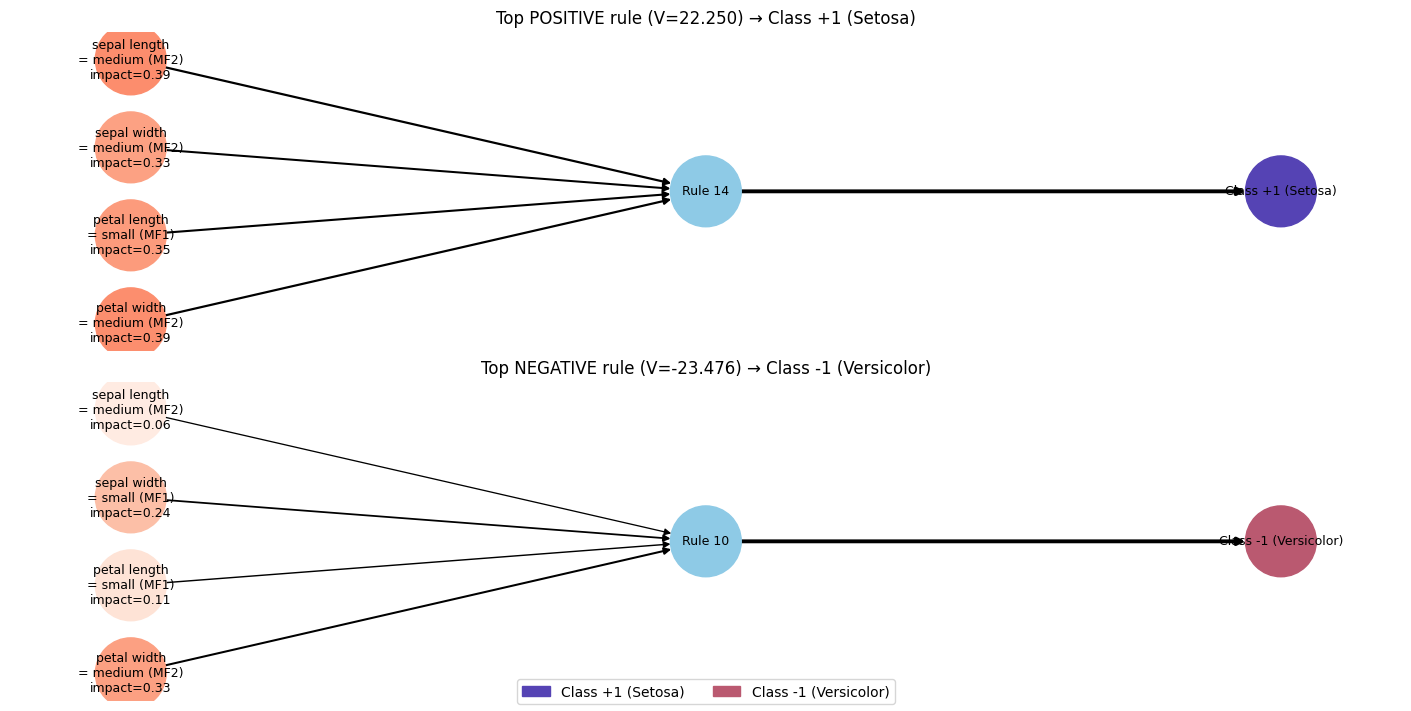

✓ Two-rule comparison plotted (outputs colored; inputs heatmapped by impact)


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches

# -----------------------------
# Customize (edit here)
# -----------------------------
FEATURE_NAMES = ["sepal length", "sepal width", "petal length", "petal width"]

MF_LABELS = {1: "small", 2: "medium", 3: "large", 4: "very large"}

# Class labels for your seminar legend (edit as needed)
# NOTE: In the notebook we used setosa vs versicolor. If you want virginica, change here.
CLASS_NAME = {+1: "Class +1 (Setosa)", -1: "Class -1 (Versicolor)"}

# Output node colors (requested: green vs orange)
CLASS_COLOR = {+1: "#5543b4", -1: "#ba5970"}  # green / orange

# Colormap for input nodes based on impact
IMPACT_CMAP = cm.Reds  # higher impact => redder


# -----------------------------
# Helpers
# -----------------------------
def safe_get_V(model):
    V = np.asarray(getattr(model, "OldV", getattr(model, "V", None)), dtype=float)
    if V.ndim > 1:
        V = V[:, 0]
    return V

def safe_get_W(model):
    W = getattr(model, "neuron_weights", None)
    if W is None:
        raise ValueError("model.neuron_weights not found. Train the model first.")
    return np.asarray(W, dtype=float)

def rule_mf_combo(model, rule_index, n_features):
    dims = [model.num_mfs] * n_features
    return np.unravel_index(rule_index, dims)  # tuple of 0-based MF indices

def draw_one_rule(ax, model, rule_index, V, W, norm):
    n_features = len(FEATURE_NAMES)
    mf_combo = rule_mf_combo(model, rule_index, n_features)

    # Determine class by sign of V
    v = float(V[rule_index])
    cls = +1 if v >= 0 else -1

    # Build small graph
    G = nx.DiGraph()
    rule_node = f"Rule_{rule_index+1}"
    out_node = f"Output_{rule_index+1}"

    G.add_node(rule_node, kind="rule", label=f"Rule {rule_index+1}")
    G.add_node(out_node, kind="output", label=f"{CLASS_NAME[cls]}")

    # Antecedents
    impacts = []
    for j in range(n_features):
        mf_idx = int(mf_combo[j]) + 1
        term = MF_LABELS.get(mf_idx, f"MF{mf_idx}")
        impact = float(W[rule_index, j])
        impacts.append(impact)

        ant_node = f"A{j+1}"
        ant_label = f"{FEATURE_NAMES[j]}\n= {term} (MF{mf_idx})\nimpact={impact:.2f}"
        G.add_node(ant_node, kind="antecedent", label=ant_label, impact=impact)

        G.add_edge(ant_node, rule_node, weight=impact)

    G.add_edge(rule_node, out_node, weight=1.0)

    # Layout: inputs (x=0), rule (x=1.2), output (x=2.4)
    pos = {}
    y_positions = np.linspace(1, 0, n_features)
    for j in range(n_features):
        pos[f"A{j+1}"] = (0.0, float(y_positions[j]))
    pos[rule_node] = (1.2, 0.5)
    pos[out_node]  = (2.4, 0.5)

    # Node colors
    node_colors = []
    for n in G.nodes():
        kind = G.nodes[n]["kind"]
        if kind == "antecedent":
            imp = float(G.nodes[n]["impact"])
            node_colors.append(IMPACT_CMAP(norm(imp)))  # heatmap
        elif kind == "rule":
            node_colors.append("#8ecae6")  # light blue
        else:
            node_colors.append(CLASS_COLOR[cls])        # green/orange output

    labels = {n: G.nodes[n]["label"] for n in G.nodes()}
    edge_widths = [0.8 + 2.0 * G.edges[e]["weight"] for e in G.edges()]


    nx.draw(
        G, pos, ax=ax,
        with_labels=True,
        labels=labels,
        node_size=2600,
        node_color=node_colors,
        font_size=9,
        arrows=True,
        width=edge_widths
    )
    ax.set_title(f"Most positive vs most negative — rule {rule_index+1}", fontsize=11)
    ax.axis("off")

    return cls, v


# -----------------------------
# Main: pick best positive and best negative rules
# -----------------------------
V = safe_get_V(model)
W = safe_get_W(model)

pos_idx = int(np.argmax(V))
neg_idx = int(np.argmin(V))

# Normalize impacts for heatmap (across ALL rules/features for consistent colors)
imp_all = W.flatten()
norm = Normalize(vmin=float(np.min(imp_all)), vmax=float(np.max(imp_all) + 1e-12))

print("✓ Selected rules:")
print("  Most positive V  -> rule", pos_idx+1, "V =", float(V[pos_idx]))
print("  Most negative V  -> rule", neg_idx+1, "V =", float(V[neg_idx]))

# -----------------------------
# Plot: two panels (one below the other)
# -----------------------------
fig, axes = plt.subplots(2, 1, figsize=(14, 7), constrained_layout=True)

cls_pos, v_pos = draw_one_rule(axes[0], model, pos_idx, V, W, norm)
cls_neg, v_neg = draw_one_rule(axes[1], model, neg_idx, V, W, norm)

axes[0].set_title(f"Top POSITIVE rule (V={v_pos:.3f}) → {CLASS_NAME[cls_pos]}", fontsize=12)
axes[1].set_title(f"Top NEGATIVE rule (V={v_neg:.3f}) → {CLASS_NAME[cls_neg]}", fontsize=12)

# Legend: output colors
legend_patches = [
    mpatches.Patch(color=CLASS_COLOR[+1], label=CLASS_NAME[+1]),
    mpatches.Patch(color=CLASS_COLOR[-1], label=CLASS_NAME[-1]),
]
fig.legend(handles=legend_patches, loc="lower center", ncol=2, frameon=True)

plt.show()

print("✓ Two-rule comparison plotted (outputs colored; inputs heatmapped by impact)")


---

## 8) Interpretability diagnostics (matrices)

You mentioned these are central in your model:

- **Consistency matrix** (from consequents `V`)
- **Similarity matrix** (from rule parameters: centers/sigmas)
- **Distinguishability / overlap** (from MF overlap)
- **Completeness** (coverage of samples above an activation threshold)

This section computes them and plots compact heatmaps (top-left block)
so you can show structure without overwhelming the audience.

✓ Imported interpretability functions from experiments.calculate
✓ Rules container type: list
✓ Number of rules: 16
✓ One rule keys: ['centers', 'sigmas']
✓ Matrices computed
C shape: (16, 16) | S shape: (16, 16) | O shape: (16, 16)


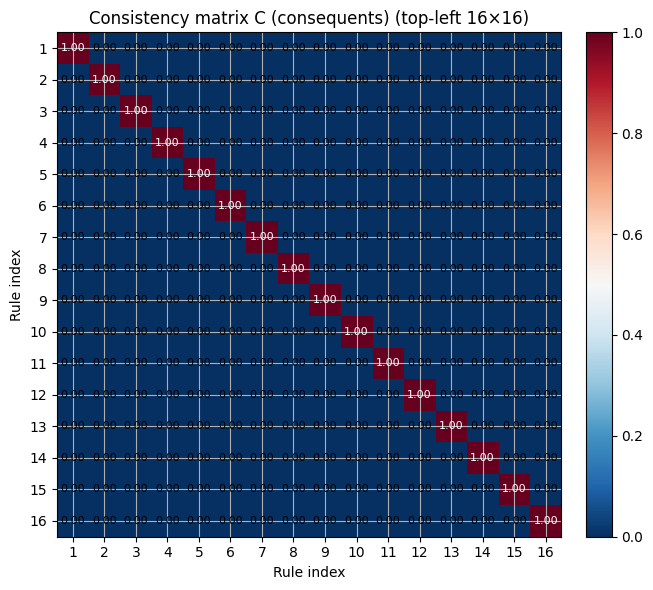


Consistency matrix C — How to read it
  High values (red) mean: rules have very similar consequents (similar outputs) → more consistent
  Low values  (blue) mean: rules have very different consequents → less consistent

Top 5 HIGHEST off-diagonal pairs:
  Rules (15, 16) = 0.000
  Rules (14, 16) = 0.000
  Rules (14, 15) = 0.000
  Rules (13, 16) = 0.000
  Rules (13, 15) = 0.000

Top 5 LOWEST off-diagonal pairs:
  Rules (1, 2) = 0.000
  Rules (1, 3) = 0.000
  Rules (1, 4) = 0.000
  Rules (1, 5) = 0.000
  Rules (1, 6) = 0.000


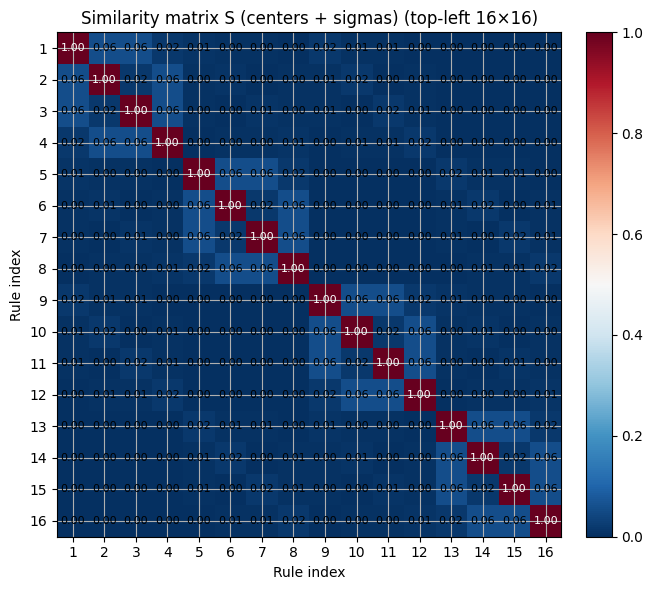


Similarity matrix S — How to read it
  High values (red) mean: rules have very similar antecedent parameters (centers/sigmas) → redundant structure
  Low values  (blue) mean: rules are structurally different in antecedents

Top 5 HIGHEST off-diagonal pairs:
  Rules (14, 16) = 0.058
  Rules (13, 15) = 0.058
  Rules (10, 12) = 0.058
  Rules (9, 11) = 0.058
  Rules (6, 8) = 0.058

Top 5 LOWEST off-diagonal pairs:
  Rules (1, 16) = 0.001
  Rules (2, 15) = 0.001
  Rules (3, 14) = 0.001
  Rules (4, 13) = 0.001
  Rules (5, 12) = 0.001


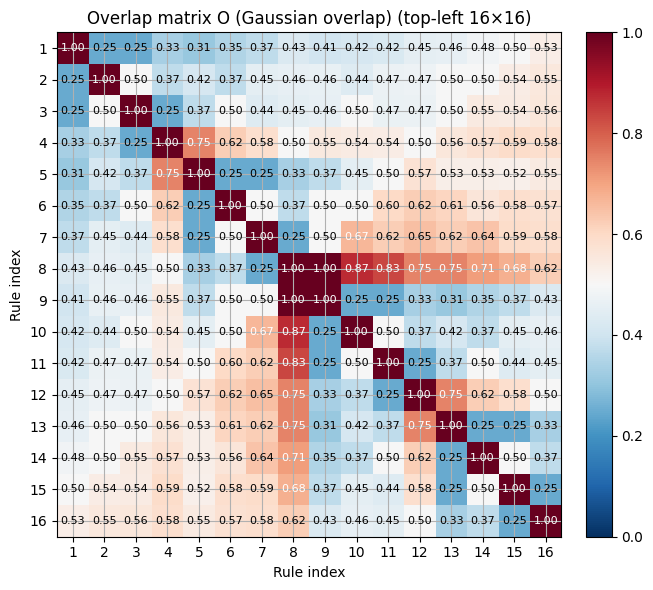


Overlap matrix O — How to read it
  High values (red) mean: rules have high overlap → LESS distinguishable (they 'cover' similar regions)
  Low values  (blue) mean: rules have low overlap → MORE distinguishable (better separation)

Top 5 HIGHEST off-diagonal pairs:
  Rules (8, 9) = 1.000
  Rules (8, 10) = 0.875
  Rules (8, 11) = 0.833
  Rules (12, 13) = 0.750
  Rules (8, 13) = 0.750

Top 5 LOWEST off-diagonal pairs:
  Rules (1, 2) = 0.250
  Rules (1, 3) = 0.250
  Rules (3, 4) = 0.250
  Rules (5, 6) = 0.250
  Rules (5, 7) = 0.250

######################################################################
e-Completeness (coverage)
  epsilon threshold: 1e-06
  Interpretation:
   - completeness close to 1.0 means: almost every sample activates at least one rule
   - low completeness means: many samples are not covered (no rule strongly activates)

  completeness = 0.943
  uncovered samples = 4 / 70
  first uncovered sample indices: [17 21 24 65]
###############################################

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 0) Try to import your "official" interpretability functions
# ============================================================
try:
    from experiments.calculate import (
        calculate_consistency_matrix,
        calculate_similarity_matrix,
        calculate_distinguishability_matrix,
        calculate_ecompleteness_and_get_uncovered_samples,
        calculate_overlap,
    )
    print("✓ Imported interpretability functions from experiments.calculate")
except Exception as e:
    print("Project import failed:", repr(e))
    print("Using local reference implementations (same spirit as your definitions).")

    def calculate_consistency_matrix(V):
        V = np.asarray(V, dtype=float)
        if V.ndim == 1:
            V = V.reshape(-1, 1)
        n = V.shape[0]
        C = np.zeros((n, n), dtype=float)
        for i in range(n):
            for j in range(i + 1, n):
                diff = np.abs(V[i] - V[j])
                C[i, j] = C[j, i] = float(np.exp(-diff).mean())
        np.fill_diagonal(C, 1.0)
        return C

    def _ovl_1d(mu1, s1, mu2, s2, n_grid=400):
        s1 = max(float(s1), 1e-9)
        s2 = max(float(s2), 1e-9)
        lo = min(mu1 - 4 * s1, mu2 - 4 * s2)
        hi = max(mu1 + 4 * s1, mu2 + 4 * s2)
        xs = np.linspace(lo, hi, n_grid)
        p1 = (1.0 / (s1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((xs - mu1) / s1) ** 2)
        p2 = (1.0 / (s2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((xs - mu2) / s2) ** 2)
        return np.trapz(np.minimum(p1, p2), xs)

    def calculate_overlap(mu1, sigma1, mu2, sigma2):
        mu1 = np.asarray(mu1, dtype=float).ravel()
        mu2 = np.asarray(mu2, dtype=float).ravel()
        sigma1 = np.asarray(sigma1, dtype=float).ravel()
        sigma2 = np.asarray(sigma2, dtype=float).ravel()
        dims = min(mu1.size, mu2.size, sigma1.size, sigma2.size)
        if dims == 0:
            return 0.0
        return float(np.mean([_ovl_1d(mu1[d], sigma1[d], mu2[d], sigma2[d]) for d in range(dims)]))

    def calculate_distinguishability_matrix(rules):
        # NOTE: this returns AVERAGE OVERLAP in [0,1]
        # Higher overlap => LESS distinguishable.
        n = len(rules)
        O = np.zeros((n, n), dtype=float)
        for i in range(n):
            for j in range(i + 1, n):
                mu1 = np.array(rules[i]["centers"])
                s1  = np.array(rules[i]["sigmas"])
                mu2 = np.array(rules[j]["centers"])
                s2  = np.array(rules[j]["sigmas"])
                ovl = calculate_overlap(mu1, s1, mu2, s2)
                O[i, j] = O[j, i] = ovl
        np.fill_diagonal(O, 1.0)
        return O

    def calculate_similarity_matrix(rules):
        n = len(rules)
        S = np.zeros((n, n), dtype=float)
        for i in range(n):
            for j in range(i + 1, n):
                ci = np.array(rules[i]["centers"], dtype=float)
                si = np.array(rules[i]["sigmas"], dtype=float)
                cj = np.array(rules[j]["centers"], dtype=float)
                sj = np.array(rules[j]["sigmas"], dtype=float)
                dist = np.sqrt(np.sum((ci - cj) ** 2 + (si - sj) ** 2))
                S[i, j] = S[j, i] = float(np.exp(-dist))
        np.fill_diagonal(S, 1.0)
        return S

    def calculate_ecompleteness_and_get_uncovered_samples(all_activations, epsilon):
        A_ = np.asarray(all_activations, dtype=float)
        is_act = A_ >= float(epsilon)
        completeness = float(np.any(is_act, axis=1).mean())
        uncovered = np.where(~np.any(is_act, axis=1))[0]
        return completeness, uncovered


# ============================================================
# 1) Get rules (dict or list) + consequents V
# ============================================================
rules_obj = model.generate_rules_dictionary()

if isinstance(rules_obj, dict):
    rules_list = list(rules_obj.values())
elif isinstance(rules_obj, list):
    rules_list = rules_obj
else:
    raise TypeError(f"Unexpected return type from generate_rules_dictionary(): {type(rules_obj)}")

print("✓ Rules container type:", type(rules_obj).__name__)
print("✓ Number of rules:", len(rules_list))
print("✓ One rule keys:", list(rules_list[0].keys()) if len(rules_list) > 0 else "N/A")

V = np.asarray(getattr(model, "OldV", getattr(model, "V")), dtype=float)
if V.ndim > 1:
    V = V[:, 0]
V = V.reshape(-1, 1)

# ============================================================
# 2) Compute matrices
# ============================================================
C = calculate_consistency_matrix(V)          # higher = more consistent
S = calculate_similarity_matrix(rules_list)  # higher = more similar
O = calculate_distinguishability_matrix(rules_list)  # higher = more overlap (less distinguishable)

print("✓ Matrices computed")
print("C shape:", C.shape, "| S shape:", S.shape, "| O shape:", O.shape)


# ============================================================
# 3) Plot helper with numbers + blue-red colors
# ============================================================
def show_matrix_with_values(M, title, max_show=16, vmin=0, vmax=1, fmt="{:.2f}", cmap="RdBu_r"):
    """
    Blue = low values, Red = high values.
    Numbers are printed in each cell for clarity.
    """
    n = min(max_show, M.shape[0])
    A = M[:n, :n]

    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(A, cmap=cmap, vmin=vmin, vmax=vmax, interpolation="nearest")

    ax.set_title(f"{title} (top-left {n}×{n})", fontsize=12)
    ax.set_xlabel("Rule index")
    ax.set_ylabel("Rule index")

    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(range(1, n + 1))
    ax.set_yticklabels(range(1, n + 1))

    # numbers inside cells
    for i in range(n):
        for j in range(n):
            val = float(A[i, j])
            # choose text color for readability
            norm_val = (val - vmin) / (vmax - vmin + 1e-12)
            text_color = "white" if norm_val > 0.65 else "black"
            ax.text(j, i, fmt.format(val), ha="center", va="center", fontsize=8, color=text_color)

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


# ============================================================
# 4) Interpretation helper (prints where things are high/low)
# ============================================================
def summarize_matrix(M, name, high_means, low_means, top_k=5):
    """
    Prints the most extreme off-diagonal pairs:
    - highest values (most similar/consistent/overlapping)
    - lowest values (least similar/consistent/overlapping)
    """
    M = np.asarray(M, dtype=float)
    n = M.shape[0]

    pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            pairs.append((float(M[i, j]), i, j))

    pairs_sorted = sorted(pairs, key=lambda x: x[0])

    lowest = pairs_sorted[:top_k]
    highest = pairs_sorted[-top_k:][::-1]

    print("\n" + "=" * 70)
    print(f"{name} — How to read it")
    print(f"  High values (red) mean: {high_means}")
    print(f"  Low values  (blue) mean: {low_means}")

    print(f"\nTop {top_k} HIGHEST off-diagonal pairs:")
    for val, i, j in highest:
        print(f"  Rules ({i+1}, {j+1}) = {val:.3f}")

    print(f"\nTop {top_k} LOWEST off-diagonal pairs:")
    for val, i, j in lowest:
        print(f"  Rules ({i+1}, {j+1}) = {val:.3f}")
    print("=" * 70)


# ============================================================
# 5) Show matrices + explanations (consistent style)
# ============================================================
MAX_SHOW = 16  # good for seminar projector; increase if you want

show_matrix_with_values(C, "Consistency matrix C (consequents)", max_show=MAX_SHOW, vmin=0, vmax=1)
summarize_matrix(
    C,
    "Consistency matrix C",
    high_means="rules have very similar consequents (similar outputs) → more consistent",
    low_means="rules have very different consequents → less consistent",
)

show_matrix_with_values(S, "Similarity matrix S (centers + sigmas)", max_show=MAX_SHOW, vmin=0, vmax=1)
summarize_matrix(
    S,
    "Similarity matrix S",
    high_means="rules have very similar antecedent parameters (centers/sigmas) → redundant structure",
    low_means="rules are structurally different in antecedents",
)

show_matrix_with_values(O, "Overlap matrix O (Gaussian overlap)", max_show=MAX_SHOW, vmin=0, vmax=1)
summarize_matrix(
    O,
    "Overlap matrix O",
    high_means="rules have high overlap → LESS distinguishable (they 'cover' similar regions)",
    low_means="rules have low overlap → MORE distinguishable (better separation)",
)

# ============================================================
# 6) e-Completeness (coverage of samples by rules)
# ============================================================
epsilon = 1e-6  # threshold for "a rule is activated"
completeness, uncovered = calculate_ecompleteness_and_get_uncovered_samples(A, epsilon)

print("\n" + "#" * 70)
print("e-Completeness (coverage)")
print(f"  epsilon threshold: {epsilon}")
print("  Interpretation:")
print("   - completeness close to 1.0 means: almost every sample activates at least one rule")
print("   - low completeness means: many samples are not covered (no rule strongly activates)")
print(f"\n  completeness = {completeness:.3f}")
print(f"  uncovered samples = {len(uncovered)} / {A.shape[0]}")

# Show a few uncovered indices for discussion
if len(uncovered) > 0:
    print("  first uncovered sample indices:", uncovered[:10])
else:
    print("  ✓ no uncovered samples at this epsilon")
print("#" * 70)

print("\n✓ Interpretability diagnostics done")


---

## 9) Research extensions (talking points)

- **Different fuzzification**: triangular / trapezoidal / bell-shaped MFs  
- **Different aggregation**: alternative t-norms / s-norms / parameterized uninorms  
- **Different consequent learning**: PSO / gradient-based optimization / regularization  
- **Pruning & merging**: use the matrices above to reduce redundancy and improve interpretability  
- **Day 2 bridge**: in streams with drift, rules should be able to **adapt over time** (evolving fuzzy systems).